# Titanic 

This notebook is my attempt to solve the Titanic problem from Kaggle: https://www.kaggle.com/competitions/titanic/overview

## 1. Problem definition

Use ML to predict wheather a passanger survived the Titanic crash or not. 

## 2. Data

I will be using data from Kaggle competition:
https://www.kaggle.com/competitions/titanic/data

## 3. Evaluation Metrics 

I will be scoring my model using method required by Kaggle: accuracy
https://www.kaggle.com/competitions/titanic/overview/evaluation

## 4. Features

**Data dictionary:**
survival - Survival	(0 = No, 1 = Yes)
pclass - Ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd)
sex - sex	
Age	- Age in years	
sibsp -	number of siblings / spouses aboard the Titanic	
parch - number of parents / children aboard the Titanic	
ticket - Ticket number	
fare - Passenger fare	
cabin - Cabin number	
embarked - Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
# Importing all the tools we will be using 

# Regular EDA (Exploratory data analysis) and ploting librarnies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Turning non-numercal values into numerical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Using sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#we want our plots to appear inside the notebook
%matplotlib inline 

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

## Load data

In [4]:
df = pd.read_csv("train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


From the dataFrame we can see, that the `Survived` is our target column. We will need to remove all the missing values from this column. We will also have to figure out a way to handle `Names` and `Cabin` - I think we can just remove them, since encoding them will create too much chaos and we have other unique values in our dataset. We will also heve to encode `Sex` and `Embarked`. Idealy we want to create one function to take care of all the transformations.

In [5]:
# Let's check how many missing values we have
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We are missing a lot of rows in `Age` column. 
We can do the following to tacke this:
* Fill the `Age` column with the median of age 

In [6]:
# Let's find out how many survivors there are
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

For more data analisys we will need to encode the data, so let's create a function that will:
* Remove `Ticket`, `Name` and `Cabin`
* Add an if statment to remove the survived dropna operation if the data frame is not a test set
* Remove all missing rows where `Survived` has a missing value
* Fil the `Age` column with the median of age
* Encode missing `Embarked` values to `unknown`
* Encode `Sex` and `Embarked` using `OneHotEncoder()`

In [105]:
# Let's create that function
def get_df_ready(df, isTestSet=False):
    # Remove all the missing values from Survived column if the dataFrame is not a test set
    if(isTestSet==False):
        df.dropna(subset=["Survived"], inplace=True) 
    
    # Remove the Name and Ticket column
    df = df.drop("Ticket", axis=1)
    df = df.drop("Name", axis=1)
    df = df.drop("Cabin", axis=1)
    
    # Fill the missing values
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df["Embarked"].fillna("unknown", inplace=True)
    
    # Encode Sex and Embarked
    categorical_features = ["Sex", "Embarked"]
    one_hot = OneHotEncoder()
    transformer = ColumnTransformer([("one_hot", 
                                 one_hot, 
                                 categorical_features)],
                                 remainder="passthrough")
    # Trasform 
    ready_df = transformer.fit_transform(df)
    # Change to a df and restore column names (they will be changed a bit because of one hot encoder)
    transformed_df = pd.DataFrame(ready_df, columns=transformer.get_feature_names_out())
    return transformed_df

In [106]:
transformed_df = get_df_ready(df, isTestSet=False)
transformed_df

,one_hot__Sex_female,one_hot__Sex_male,one_hot__Embarked_C,one_hot__Embarked_Q,one_hot__Embarked_S,one_hot__Embarked_unknown,remainder__PassengerId,remainder__Survived,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,1.0,0.0,0.0,1.0,0.0,5.0,0.0,3.0,35.0,0.0,0.0,8.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,887.0,0.0,2.0,27.0,0.0,0.0,13.0000
887,1.0,0.0,0.0,0.0,1.0,0.0,888.0,1.0,1.0,19.0,0.0,0.0,30.0000
888,1.0,0.0,0.0,0.0,1.0,0.0,889.0,0.0,3.0,28.0,1.0,2.0,23.4500
889,0.0,1.0,1.0,0.0,0.0,0.0,890.0,1.0,1.0,26.0,0.0,0.0,30.0000


I could also write a for loop for sex columnt to put 0 if male and 1 if female, but that is not necessary. 

In [10]:
# Let's see if we still have any non-numerical data
transformed_df.dtypes

one_hot__Sex_female          float64
one_hot__Sex_male            float64
one_hot__Embarked_C          float64
one_hot__Embarked_Q          float64
one_hot__Embarked_S          float64
one_hot__Embarked_unknown    float64
remainder__PassengerId       float64
remainder__Survived          float64
remainder__Pclass            float64
remainder__Age               float64
remainder__SibSp             float64
remainder__Parch             float64
remainder__Fare              float64
dtype: object

### Spliting the data

In [11]:
# Let's create X and Y
X = transformed_df.drop("remainder__Survived", axis=1)
y = transformed_df["remainder__Survived"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Choosing the model
Now since all of our data is ready and split we can move on to picking models. We will check the scikit learn map to see which model could we use: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

We are going to try:
* LinearSVC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
* SVC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
* KNN (https://scikit-learn.org/stable/modules/neighbors.html)
* LogisticRegression (https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* RandomForestClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
* AdaBoost (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

**Note:** Remember to import all the models!!!

Because we want to try so many different models we will create a dictionary with all of our models, fit them and evaluate them using accuracy. 

In [12]:
# Import all the models 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [13]:
# Create a model dictionary
model_dict = {
    "LinearSVC": LinearSVC(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier()
}

Now let's create a function that will:
* take model dictionary as a parameter
* fit all the model to our data
* score all the models using accuracy
* put the name and the score of the model in results dictionary
* return the results dictionary

In [14]:
# Create fit_and_score function
def fit_and_score(model_dictionary):
    """
    This function takes as an input a dictionary of models, fits and scoress all of the models using accuracy.
    """
    # Set random seed
    np.random.seed(42)
    
    # Create an empty results dictionary 
    results = {}
    
    for name, model in model_dictionary.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Score the model using accuracy and add the results
        results[name] = cross_val_score(model, X_test, y_test, cv=5, scoring="accuracy").mean()
    # Return the results dictionary
    return results

**Note:** I have decided to add the `%%time` magic function to monitor how long does it take for columns to run. 

In [15]:
%%time
# Let's call our function
models_score = fit_and_score(model_dict)

C:\Users\jakub\titanic_ml_project\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\titanic_ml_project\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\titanic_ml_project\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\titanic_ml_project\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\titanic_ml_project\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\titanic_ml_project\env\lib\site-packages\sklearn\svm\_base.p

CPU times: total: 312 ms
Wall time: 1.22 s


In [16]:
models_score

{'LinearSVC': 0.7546031746031747,
 'SVC': 0.6201587301587301,
 'KNN': 0.636984126984127,
 'LogisticRegression': 0.8492063492063492,
 'RandomForestClassifier': 0.8380952380952381,
 'AdaBoostClassifier': 0.7653968253968253}

<AxesSubplot:>

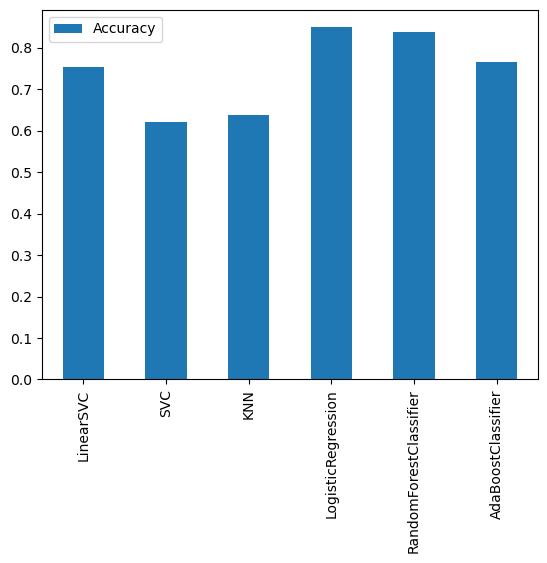

In [17]:
# Let's visualize the results
models_score_df = pd.DataFrame(models_score, index=["Accuracy"])
models_score_df.T.plot.bar()

## Hyperparameter tuning

Some of our model did quite well, but some did below our expectations. We got a lot of warnings saying we should increase the number of iterators to get better results. These warnings were for:
* LinearSVC 
* LogisticRegression

I will try to optimize `SVC` using `GridSearchCV` in the first place, because it is performing the worst out of all and we will see if we can get more out of it.
I did some reaserch on how can I improve my `SVC` model and came across this article on Medium: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

**Note:** This and next `GridSearchCV`s will run for a long time. I think it may be a good idea to save each model after we run the `GridSearchCV`. Remember - the `%%time` magic function will tell you exactly how long did the cell run for. Before runing the code make sure you have something else to do while waiting for this code to run. 

The cell below was runing for almost 10 hours without a result, so it's either broken or it just takes this long for my laptop to process. 

In [ ]:
%%time
# GridSearchCV for SVC
svc_grid = {"C": (0.1, 1, 10, 100, 1000),
            "gamma": (0.1, 1, 10, 100),
            "kernel": ("linear", "rbf", "poly")}

# Setup GridSearchCV for SVC
gs_svc = GridSearchCV(SVC(),
                      param_grid=svc_grid,
                      cv=5,
                      verbose=True)
gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [17]:
gs_svc.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [18]:
# Let's create a dictionary, where we will store updated models' values
updated_models_scores = {}

In [ ]:
updated_models_scores["SVC"] = gs_svc.score(X_test, y_test)

We can see a big improvement in our SVC model, but it's still performing similarly to other models baseline score, so I think we will park this model for now.

I will use `GridSearchCV` to find the best version of `LinearSVC` and `LogisticRegression`. If we will see an improvement in scores we will procced with other hyperparameter tuning. 

I will start with `LogisticRegression`. My picks for grid are based on this article from Medium: 
https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69

In [19]:
%%time
# Setup GridSearchCV for LogisticRegression
logistic_regression_grid = {"C": (0.1, 1, 10, 100, 1000),
                            "max_iter": np.arange(100,1000,100)}
gs_logistic_regression = GridSearchCV(LogisticRegression(n_jobs=-1),
                                      param_grid=logistic_regression_grid,
                                      cv=5,
                                      verbose=True)
gs_logistic_regression.fit(X_train, y_train);

Fitting 5 folds for each of 45 candidates, totalling 225 fits
CPU times: total: 188 ms
Wall time: 17 s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': (0.1, 1, 10, 100, 1000),
                         'max_iter': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             verbose=True)

In [20]:
gs_logistic_regression.best_params_

{'C': 0.1, 'max_iter': 300}

In [21]:
# Let's score the model and add the new score to our updated scores dictionary
updated_models_scores["LogisticRegression"] = gs_logistic_regression.score(X_test, y_test)
updated_models_scores["LogisticRegression"], models_score["LogisticRegression"]

(0.8324022346368715, 0.8492063492063492)

There is no improvement in `LogisticRegression`, in fact I think I performed worst (I'm not sure how), so we will move on to optimizing `LinearSVC`. For my picks to the grid I used this article: 
https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb

(I skiped the `kernel`, because then some of the other values would not work - you will see what I mean if you take a look at the article above).

In [37]:
%%time
# Setup GridSearchCV for LinearnSVC
linear_svc_grid = {"C": (0.1, 1, 10, 100, 1000)}
gs_linear_svc = GridSearchCV(LinearSVC(),
                             param_grid=linear_svc_grid,
                             cv=5,
                             verbose=True, 
                             n_jobs=-1)
gs_linear_svc.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 46.9 ms
Wall time: 164 ms


C:\Users\jakub\titanic_ml_project\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': (0.1, 1, 10, 100, 1000)}, verbose=True)

In [38]:
gs_linear_svc.best_params_

{'C': 1000}

In [39]:
# Add to updated scores dictionary 
updated_models_scores["LinearSVC"] = gs_linear_svc.score(X_test, y_test)
updated_models_scores["LinearSVC"], models_score["LinearSVC"]

(0.8156424581005587, 0.7546031746031747)

There is an improvement and it's quite big. Mayby if I tried more hyperparameters, or had data shaped the other way or used optimizers the score would be higher. I tried searching with different number of iterations - `max_iter`, but my model scored way lower, so I just removed the option for searching with `max_iter`. The best result I could get was with `"C"=1000`. 

In [32]:
# Let's see what other models can be improved
models_score

{'LinearSVC': 0.7546031746031747,
 'SVC': 0.6201587301587301,
 'KNN': 0.636984126984127,
 'LogisticRegression': 0.8492063492063492,
 'RandomForestClassifier': 0.8380952380952381,
 'AdaBoostClassifier': 0.7653968253968253}

We can still try to improve hyperparameters for `RandomForestClassifier` and `AdaBoostClassifier`. We will start with the first one. I used this article to pick my values for the grid: https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [41]:
%%time
# Setup GridSearchCV for RandomForestClassifier
random_forest_clf_grid = {"n_estimators": np.arange(100, 2000, 100),
                          "max_depth": (5, 8, 15, 25, 30),
                          "min_samples_split": (2, 5, 10, 15, 100),
                          "min_samples_leaf": (1, 2, 5, 10)}
gs_random_forest_clf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                                    param_grid=random_forest_clf_grid,
                                    cv=5,
                                    verbose=True,
                                    n_jobs=-1)
gs_random_forest_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits


KeyboardInterrupt: 

In [ ]:
gs_random_forest_clf.best_params_

In [ ]:
# Add the score to dictionary
updated_models_scores["RandomForestClassifier"] = gs_random_forest_clf.score(X_test, y_test)

In [ ]:
# Let's save our improved model in case something goes wrong
import pickle
pickle.dump(gs_random_forest_clf, open("gs_random_forest_clf_1.pkl", "wb"))

In [44]:
import pickle
loaded_random_forest_clf = pickle.load(open("gs_random_forest_clf_1.pkl", "rb"))
updated_models_scores["RandomForestClassifier"] = loaded_random_forest_clf.score(X_test, y_test)

Now we have saved our model (so when we revisit this notebook we don't have to wait about 1-2h for every thing to run) and we can tune the hyperparameters for our last model - `AdaBoostClassifier`. I used this article to help me decide which hyperparameters should I try: https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20

In [46]:
%%time
# Setup GridSearchCV for AdaBoostClassiffier
ada_boost_clf_grid = {"n_estimators": (10, 50, 100, 500, 1000, 5000),
                      "learning_rate": np.arange(0.1, 2.1, 0.1)}
gs_ada_boost_clf = GridSearchCV(AdaBoostClassifier(),
                                param_grid=ada_boost_clf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)
gs_ada_boost_clf.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
CPU times: total: 1.72 s
Wall time: 6min 2s


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'n_estimators': (10, 50, 100, 500, 1000, 5000)},
             verbose=True)

In [47]:
# Add the score to dictionary
updated_models_scores["AdaBoostClassifier"] = gs_ada_boost_clf.score(X_test, y_test)
updated_models_scores["AdaBoostClassifier"], models_score["AdaBoostClassifier"]

(0.8324022346368715, 0.7653968253968253)

In [203]:
# Viev the updated models' scores 
updated_models_scores

{'LogisticRegression': 0.8324022346368715,
 'LinearSVC': 0.8156424581005587,
 'RandomForestClassifier': 0.9329608938547486,
 'AdaBoostClassifier': 0.8324022346368715}

In [97]:
# Create a data frame of models scores so we can compare them
models_scores_df = pd.DataFrame([models_score, updated_models_scores])
models_scores_df

,LinearSVC,SVC,KNN,LogisticRegression,RandomForestClassifier,AdaBoostClassifier
0,0.754603,0.620159,0.636984,0.849206,0.838095,0.765397
1,0.815642,NaN,NaN,0.832402,0.932961,0.832402


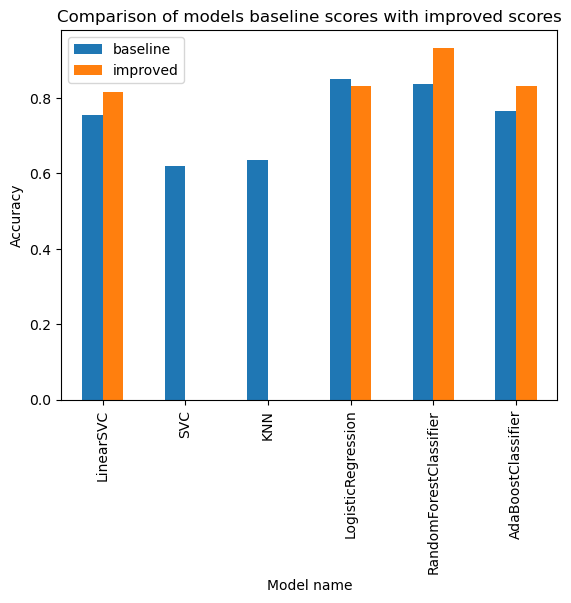

In [114]:
# Visualize the models scores and compare them
plot = models_scores_df.T.plot.bar();
plt.legend(['baseline', 'improved']);
plt.title("Comparison of models baseline scores with improved scores")
plt.xlabel("Model name")
plt.ylabel("Accuracy")
plt.savefig("Models_scores_comperation.jpg")

From the graph above we can clearly se that the impoved `RandomForestClassiffier` is performing the best out of all with about 93% accuracy! 

## Making predictions

In [153]:
# Import the test data
test_df = pd.read_csv("test.csv")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [154]:
# Transforming test_df using our fuction
transformed_test_df = get_df_ready(test_df, isTestSet=True)
transformed_test_df

,one_hot__Sex_female,one_hot__Sex_male,one_hot__Embarked_C,one_hot__Embarked_Q,one_hot__Embarked_S,remainder__PassengerId,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,0.0,1.0,0.0,1.0,0.0,892.0,3.0,34.5,0.0,0.0,7.8292
1,1.0,0.0,0.0,0.0,1.0,893.0,3.0,47.0,1.0,0.0,7.0000
2,0.0,1.0,0.0,1.0,0.0,894.0,2.0,62.0,0.0,0.0,9.6875
3,0.0,1.0,0.0,0.0,1.0,895.0,3.0,27.0,0.0,0.0,8.6625
4,1.0,0.0,0.0,0.0,1.0,896.0,3.0,22.0,1.0,1.0,12.2875
...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,1.0,0.0,0.0,1.0,1305.0,3.0,27.0,0.0,0.0,8.0500
414,1.0,0.0,1.0,0.0,0.0,1306.0,1.0,39.0,0.0,0.0,108.9000
415,0.0,1.0,0.0,0.0,1.0,1307.0,3.0,38.5,0.0,0.0,7.2500
416,0.0,1.0,0.0,0.0,1.0,1308.0,3.0,27.0,0.0,0.0,8.0500


In [155]:
transformed_test_df.isna().sum()

one_hot__Sex_female       0
one_hot__Sex_male         0
one_hot__Embarked_C       0
one_hot__Embarked_Q       0
one_hot__Embarked_S       0
remainder__PassengerId    0
remainder__Pclass         0
remainder__Age            0
remainder__SibSp          0
remainder__Parch          0
remainder__Fare           1
dtype: int64

In [156]:
transformed_test_df.remainder__Fare.fillna(value=transformed_test_df.remainder__Fare.median(), inplace=True)
transformed_test_df.isna().sum()

In [158]:
X_train

,one_hot__Sex_female,one_hot__Sex_male,one_hot__Embarked_C,one_hot__Embarked_Q,one_hot__Embarked_S,one_hot__Embarked_unknown,remainder__PassengerId,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
883,0.0,1.0,0.0,0.0,1.0,0.0,884.0,2.0,28.0,0.0,0.0,10.5000
577,1.0,0.0,0.0,0.0,1.0,0.0,578.0,1.0,39.0,1.0,0.0,55.9000
31,1.0,0.0,1.0,0.0,0.0,0.0,32.0,1.0,28.0,1.0,0.0,146.5208
777,1.0,0.0,0.0,0.0,1.0,0.0,778.0,3.0,5.0,0.0,0.0,12.4750
787,0.0,1.0,0.0,1.0,0.0,0.0,788.0,3.0,8.0,4.0,1.0,29.1250
...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.0,1.0,0.0,0.0,1.0,0.0,736.0,3.0,28.5,0.0,0.0,16.1000
32,1.0,0.0,0.0,1.0,0.0,0.0,33.0,3.0,28.0,0.0,0.0,7.7500
570,0.0,1.0,0.0,0.0,1.0,0.0,571.0,2.0,62.0,0.0,0.0,10.5000
433,0.0,1.0,0.0,0.0,1.0,0.0,434.0,3.0,17.0,0.0,0.0,7.1250


There is a small problem, because in our training dataset we had a column embarked_unknown because we had missing values. In the test dataset we don't have this issue, so we are missing one column, which i will add mannualy and it will be filled with zeros. 

In [159]:
# Adding that one missing column and setting all the values to 0, because there were no NaNs in the Embarked column
transformed_test_df["one_hot__Embarked_unknown"] = 0

# Reorder the dataFrame as the original, training one
transformed_test_df = transformed_test_df[["one_hot__Sex_female", "one_hot__Sex_male", "one_hot__Embarked_C", "one_hot__Embarked_Q", "one_hot__Embarked_S","one_hot__Embarked_unknown","remainder__PassengerId","remainder__Pclass","remainder__Age","remainder__SibSp","remainder__Parch","remainder__Fare"]]

Now everything seems to be okay.

In [195]:
# Make predictions
predictions = loaded_random_forest_clf.predict(transformed_test_df)
predictions

In [197]:
# Create a data frame so we can export predictions to .csv file later
predictions_df = pd.DataFrame(columns=("PassengerId", "Survived"))

In [198]:
# Add data to the predictions_df and change values into integers
predictions_df["PassengerId"] = transformed_test_df["remainder__PassengerId"].astype(int)
predictions_df["Survived"] = predictions.astype(int)

In [199]:
predictions_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [200]:
# Set the index od the data frame to PassengerId so that our data frame has the required shape 
predictions_df.set_index("PassengerId", inplace=True)
predictions_df

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [201]:
# Create a .csv file from the predictions_df 
predictions_df.to_csv("predictions.csv")

## The end

In conclusion we have created a model with 93% accuracy. Here are some things that could be improved:
* Changing `Sex` column into 1 if female and 0 if male (saving some space)
* Adding optimizers to our models
* Adding some data standarization function

Thank You for reading!

This notebook was made by Jakub Kuliński 03.05.2023 